#Table of Content

	1.	Data Loading and Preprocessing: Load the video frames and preprocess them.
	2.	Define a CNN Model: A basic CNN architecture will be implemented.
	3.	Train the CNN: Train the CNN to classify frames as flipping or not flipping.
	4.	Evaluate the Model: Evaluate the model’s performance using accuracy and loss.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Apziva/images.zip'

# Extract the zip file
extracted_folder = '/content/drive/MyDrive/Apziva/extracted_images'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print(f"Dataset extracted to: {extracted_folder}")

NameError: name 'zipfile' is not defined

##1.    Data Loading and Preprocessing

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision.transforms import ToTensor

# Dataset class to load images from both training and testing folders
class FrameDataset(Dataset):
    def __init__(self, data_directory, transform=None):
        self.data_directory = data_directory
        self.transform = transform
        self.images = []  # Store image file paths
        self.labels = []  # Store corresponding labels (0: not flip, 1: flip)

        # Iterate through the subdirectories (flip and not_flip)
        for label_dir in ['flip', 'notflip']:
            full_dir = os.path.join(data_directory, label_dir)
            label = 0 if label_dir == 'notflip' else 1  # Assign label 0 (not flip) or 1 (flip)

            # Iterate through each image file in the directory
            for file_name in os.listdir(full_dir):
                img_path = os.path.join(full_dir, file_name)
                self.images.append(img_path)  # Append image file path to the list
                self.labels.append(label)  # Append corresponding label to the list

    def __len__(self):
        return len(self.images)  # Return the total number of images

    def __getitem__(self, idx):
        img_path = self.images[idx]  # Get the image path for the given index
        image = Image.open(img_path).convert("RGB")  # Open image using PIL and convert to RGB

        if self.transform:
            image = self.transform(image)  # Apply transformations

        label = self.labels[idx]  # Get the corresponding label
        return image, label  # Return the image and its label

In [19]:
from torchvision import transforms

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels, numbers dependent on model selection
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images dependents on the pre-train model
])

# Paths to the training and testing directories
train_directory = '/content/drive/MyDrive/Apziva/extracted_images/images/training'
test_directory = '/content/drive/MyDrive/Apziva/extracted_images/images/testing'

# Create training and testing datasets
train_dataset = FrameDataset(train_directory, transform=transform)
test_dataset = FrameDataset(test_directory, transform=transform)

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle the training data, bath size denpendents on cup/gpu performance
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # No need to shuffle the testing data

# Print number of images in training and testing datasets
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")

Number of training images: 2392
Number of testing images: 597


In [20]:
for X, y in test_loader:
    print(f"Shape of x [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [N, C, H, W]: torch.Size([32, 3, 128, 128])
Shape of y: torch.Size([32]) torch.int64


##2.    Define a CNN Model

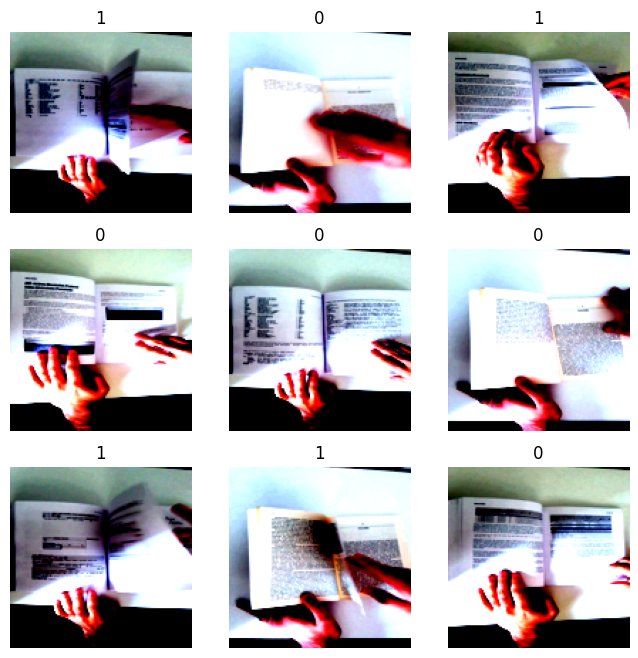

In [21]:
from torch import nn
import matplotlib.pyplot as plt

# Visualize the sample data from training set
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    image, label = train_dataset[sample_idx]

    image = image.permute(1, 2, 0).numpy()

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(image)
plt.show()


In [6]:
# See first training sample
image, label = train_dataset[0]
image, label

(tensor([[[ 0.5193,  0.5022,  0.5022,  ..., -0.6109, -0.7308, -0.7822],
          [ 0.5193,  0.5193,  0.5022,  ...,  0.5707,  0.5193,  0.4337],
          [ 0.5193,  0.5193,  0.5022,  ...,  0.6734,  0.6906,  0.6392],
          ...,
          [-2.0665, -2.0665, -2.0665,  ..., -2.0837, -2.0837, -2.1008],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0837, -2.0837, -2.0837],
          [-2.0494, -2.0494, -2.0494,  ..., -2.0837, -2.0837, -2.0837]],
 
         [[ 0.5553,  0.6254,  0.6254,  ..., -0.5476, -0.6352, -0.7227],
          [ 0.5728,  0.6254,  0.6254,  ...,  0.6604,  0.6078,  0.5728],
          [ 0.5378,  0.5903,  0.6078,  ...,  0.7829,  0.7829,  0.8004],
          ...,
          [-1.9832, -1.9832, -1.9832,  ..., -2.0007, -2.0007, -2.0182],
          [-1.9657, -1.9657, -1.9657,  ..., -2.0007, -2.0007, -2.0007],
          [-1.9657, -1.9657, -1.9482,  ..., -2.0007, -2.0007, -2.0007]],
 
         [[ 0.4265,  0.3568,  0.4091,  ..., -0.5670, -0.6715, -0.7413],
          [ 0.4439,  0.3916,

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class FlipCNN(nn.Module):
    def __init__(self):
        super(FlipCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  #combination

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust based on input image size
        self.fc2 = nn.Linear(512, 2)  # Output layer (2 classes: flipping or not flipping)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        # Classifier

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 128 * 16 * 16)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Instantiate the model, loss function, and optimizer
model = FlipCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Create train & test loop functions

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  train_loss = 0
  correct = 0
  for batch, (X, y) in enumerate(dataloader):
    # Compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  train_loss /= len(dataloader)
  train_accuracy = correct / size

  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)


def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  test_accuracy = correct / size
  print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)


In [24]:
# Test the model and get a single image from the test dataset
image, label = test_dataset[0]

# Add a batch dimension (necessary for the model)
image = image.unsqueeze(0)

# Put the model in evaluation mode
model.eval()

# Perform a forward pass
with torch.no_grad():
  output = model(image)

# Print the output
print(output)

# Get the predicted class
predicted_class = torch.argmax(output).item()

# Print the predicted class and the actual label
print(f"Predicted class: {predicted_class}")
print(f"Actual label: {label}")


tensor([[-0.0139,  0.0047]])
Predicted class: 1
Actual label: 1


In [10]:
# Use torchinfo to get an idea of the shapes going through model

!pip install torchinfo
from torchinfo import summary

summary(model, input_size=(32, 3, 128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
FlipCNN                                  [32, 2]                   --
├─Conv2d: 1-1                            [32, 32, 128, 128]        896
├─MaxPool2d: 1-2                         [32, 32, 64, 64]          --
├─Conv2d: 1-3                            [32, 64, 64, 64]          18,496
├─MaxPool2d: 1-4                         [32, 64, 32, 32]          --
├─Conv2d: 1-5                            [32, 128, 32, 32]         73,856
├─MaxPool2d: 1-6                         [32, 128, 16, 16]         --
├─Linear: 1-7                            [32, 512]                 16,777,728
├─Dropout: 1-8                           [32, 512]                 --
├─Linear: 1-9                            [32, 2]                   1,026
Total params: 16,872,002
Trainable params: 16,872,002
Non-trainable params: 0
Total mult-adds (G): 5.85
Input size (MB): 6.29
Forward/backward pass size (MB): 235.01
Params size (MB): 67.49
Estimated Total

In [ ]:
# Train and evaluate the FlipCNN model

epochs = 5  # Number of training epochs
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.689695  [    0/ 2392]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.234239 

Epoch 2
-------------------------------
loss: 0.340961  [    0/ 2392]
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.100830 

Epoch 3
-------------------------------
loss: 0.062704  [    0/ 2392]
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.053536 

Epoch 4
-------------------------------
loss: 0.037693  [    0/ 2392]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.033297 

Epoch 5
-------------------------------
loss: 0.027163  [    0/ 2392]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.025089 

Done!


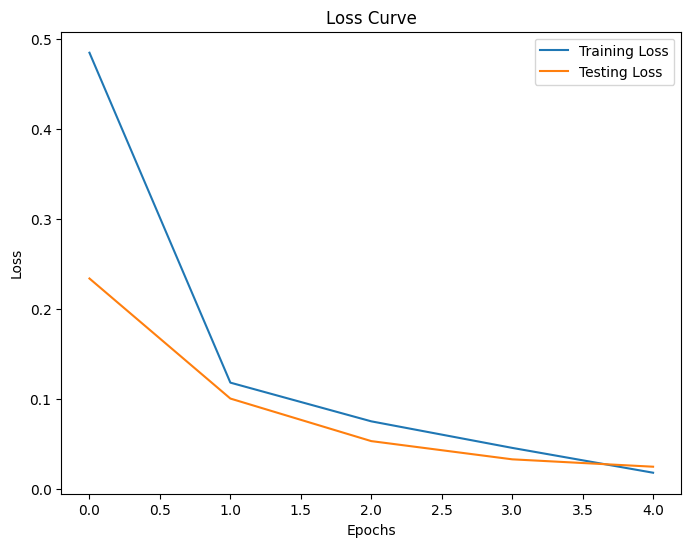

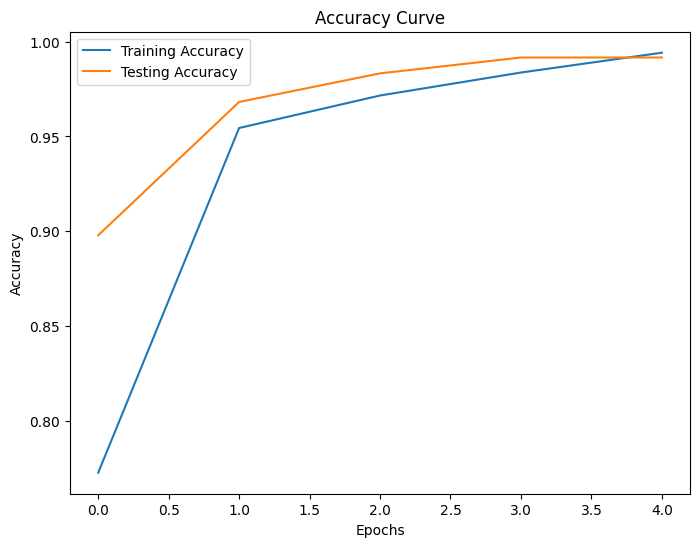

In [ ]:
# Extract the train loss, test loss,  train accuracy and test accuracy plot a loss curve with loss and accuracy

import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


In [25]:
# Use a Recurrent Neural Network (RNN) LSTM on the sequence of frames to enhance the model’s understanding.


class FlipLSTMCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(FlipLSTMCNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # LSTM
        self.lstm = nn.LSTM(128 * 16 * 16, 256, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(256, num_classes)


    def forward(self, x):

        batch_size, sequence_length, channels, height, width = x.shape

        # Reshape for CNN input: (batch_size * sequence_length, channels, height, width)
        x = x.view(batch_size * sequence_length, channels, height, width)

        # Pass through CNN
        x = self.cnn(x)

        # Flatten the output of CNN
        x = x.view(batch_size, sequence_length, -1)

        # Pass through LSTM
        x, _ = self.lstm(x)

        # Get the last hidden state of LSTM
        x = x[:, -1, :]

        # Pass through fully connected layer
        x = self.fc(x)
        return x

# Instantiate the LSTM-CNN model
lstm_cnn_model = FlipLSTMCNN()

# Define loss function and optimizer
loss_fn_sq = nn.CrossEntropyLoss()
optimizer_sq = optim.Adam(lstm_cnn_model.parameters(), lr=0.001)



In [26]:
train_losses_lstm = []
test_losses_lstm = []
train_accuracies_lstm = []
test_accuracies_lstm = []


def train_loop_lstm(dataloader, model, loss_fn_sq, optimizer_sq):
  size = len(dataloader.dataset)
  train_loss, correct = 0 , 0

  for batch, (X, y) in enumerate(dataloader):
    # Reshape X to add a sequence dimension of 1
    X = X.unsqueeze(1)  # Add a dimension for sequence length

    pred = model(X)
    loss = loss_fn_sq(pred, y)
    optimizer = optimizer_sq

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  train_loss /= len(dataloader)
  train_accuracy = correct / size

  train_losses_lstm.append(train_loss)
  train_accuracies_lstm.append(train_accuracy)

def test_loop_lstm(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0 , 0

  with torch.no_grad():
    for X, y in dataloader:
      # Reshape X to add a sequence dimension of 1
      X = X.unsqueeze(1)  # Add a dimension for sequence length

      pred = model(X)
      test_loss += loss_fn_sq(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  test_accuracy = correct / size
  print(f"Test Error: \n Accuracy: {(100 * test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  test_losses_lstm.append(test_loss)
  test_accuracies_lstm.append(test_accuracy)


In [27]:
# Train and evaluate the fliplstmcnn model

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_lstm(train_loader, lstm_cnn_model, loss_fn_sq, optimizer_sq)
    test_loop_lstm(test_loader, lstm_cnn_model, loss_fn_sq)


Epoch 1
-------------------------------
loss: 0.692299  [    0/ 2392]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.311528 

Epoch 2
-------------------------------
loss: 0.333675  [    0/ 2392]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.102400 

Epoch 3
-------------------------------
loss: 0.092205  [    0/ 2392]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.050296 

Epoch 4
-------------------------------
loss: 0.030567  [    0/ 2392]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.032863 

Epoch 5
-------------------------------
loss: 0.012304  [    0/ 2392]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.031985 



In [28]:
# Test the model and get a single image from the test dataset
image, label = test_dataset[0]

# Add a batch dimension and sequence dimension (necessary for the model)
image = image.unsqueeze(0).unsqueeze(1)

# Put the model in evaluation mode
lstm_cnn_model.eval()

# Perform a forward pass
with torch.no_grad():
  output = lstm_cnn_model(image)

# Print the output
print(output)

# Get the predicted class
predicted_class = torch.argmax(output).item()

# Print the predicted class and the actual label
print(f"Predicted class: {predicted_class}")
print(f"Actual label: {label}")

# Get multiple images from the test dataset for testing
num_images_to_test = 5

for i in range(num_images_to_test):
    image, label = test_dataset[i]

    # Add a batch dimension and sequence dimension
    image = image.unsqueeze(0).unsqueeze(1)

    # Put the model in evaluation mode
    lstm_cnn_model.eval()

    # Perform a forward pass
    with torch.no_grad():
        output = lstm_cnn_model(image)

    # Get the predicted class
    predicted_class = torch.argmax(output).item()

    # Print the predicted class and the actual label
    print(f"Image {i+1}:")
    print(f"  Predicted class: {predicted_class}")
    print(f"  Actual label: {label}")


tensor([[-3.4410,  3.3111]])
Predicted class: 1
Actual label: 1
Image 1:
  Predicted class: 1
  Actual label: 1
Image 2:
  Predicted class: 1
  Actual label: 1
Image 3:
  Predicted class: 1
  Actual label: 1
Image 4:
  Predicted class: 1
  Actual label: 1
Image 5:
  Predicted class: 1
  Actual label: 1


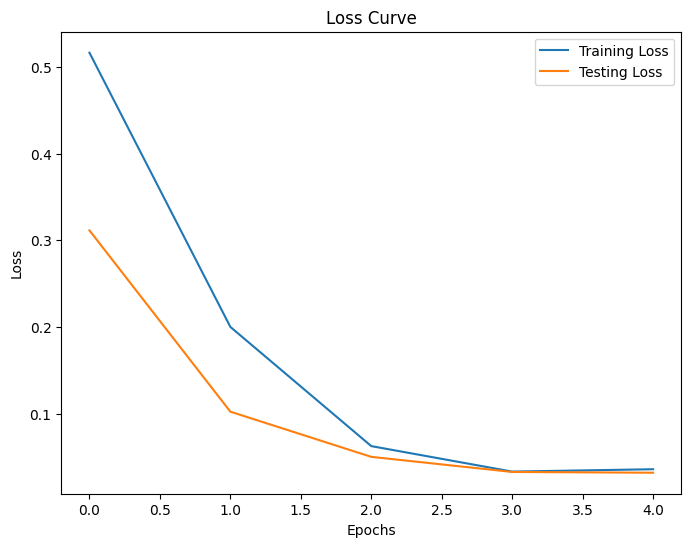

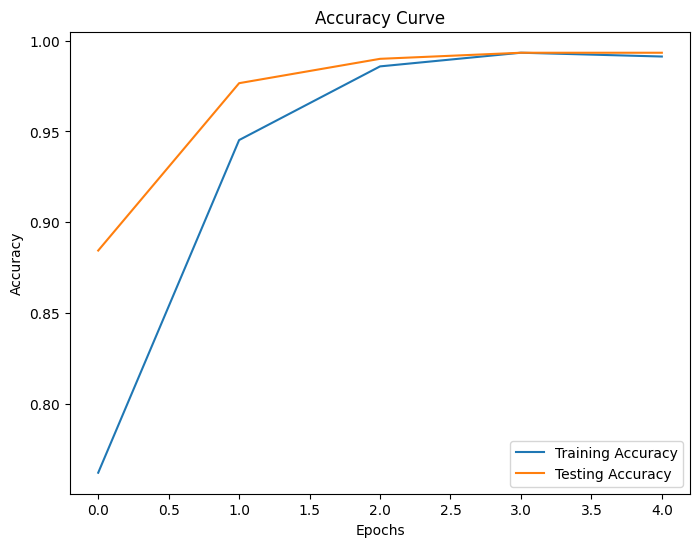

In [29]:

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses_lstm, label='Training Loss')
plt.plot(test_losses_lstm, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Plot the accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies_lstm, label='Training Accuracy')
plt.plot(test_accuracies_lstm, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()
